<a href="https://colab.research.google.com/github/mkpvasu/ML-and-Perception/blob/main/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import PIL.ImageOps
import os
import tqdm

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
!nvidia-smi

Thu May 26 02:45:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print(torch.__version__)

1.11.0+cu113


Loading Face lfw Data

Face lfw dataset contains labeled images for training, validation and testing our network.

In [4]:
!rm -rf lfw-deepfunneled
!rm -rf lfw-deepfunneled-val

In [5]:
# Download dataset
! wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -xvzf /content/lfw-deepfunneled.tgz

os.mkdir('/content/lfw-deepfunneled-val')

train_dir='/content/lfw-deepfunneled'
val_dir='/content/lfw-deepfunneled-val'
total=len(os.listdir(train_dir))
print(f'TOTAL: {total}')
train_cls = int(total*0.8)
val_cls = total - train_cls

for _ in range(val_cls):
  ran_dir=random.choice(os.listdir(train_dir))
  os.rename(f"{train_dir}/{ran_dir}", f"{val_dir}/{ran_dir}")

print(f'CURRENT TOTAL TRAIN: {len(os.listdir(train_dir))}')

Streaming output truncated to the last 5000 lines.
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0014.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0015.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0016.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg
lfw-deepfunne

In [6]:
!mkdir savemodels

In [7]:
#Displaying images
def imshow(img, caption = None):
  npimg = img.numpy()
  plt.axis("off") #Avoid displaying axis for images
  if caption:
    plt.text(50, 10, caption, fontstyle = 'italic', fontfamily = "cursive", fontsize = 'medium', fontweight = 'demibold',
            bbox = {'facecolor':'blue', 'alpha':0.6, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#Plotting data
def show_plt(iter, loss):
  plt.plot(iter, loss)
  plt.show()

In [8]:
# Model
class Siamese_Net(nn.Module):
  def __init__(self):
    super(Siamese_Net,self).__init__()

    self.conv1=nn.Conv2d(1,64,10)
    self.conv2=nn.Conv2d(64,128,7)
    self.conv3=nn.Conv2d(128,128,4)
    self.conv4=nn.Conv2d(128,256,4)

    self.Linear1=nn.Linear(9216,4096)
    self.flatten=nn.Flatten()
    self.Linear2=nn.Linear(4096,1)

    self.relu=nn.ReLU()
    self.maxP=nn.MaxPool2d(2)
    self.sigm=nn.Sigmoid()

    # self.initialize_weights()

  def twin(self,x):

    out=self.conv1(x)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv2(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv3(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv4(out)
    out=self.relu(out)

    # test=out.view(out.size()[0], -1)
    out=self.flatten(out)
    # print(test==out) ##result -> true

    out=self.Linear1(out)
    out=self.sigm(out)

    return out

  def forward(self,x1,x2):

    x1_out=self.twin(x1)
    x2_out=self.twin(x2)

    # score= linear(distance between vectors)
    score=self.Linear2(torch.abs(x1_out-x2_out))

    # print(score)
    
    return score

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,0,1e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)
      if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight,0,2e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)

In [9]:
#testing
net=Siamese_Net()
# print(net)
dummyx1=torch.randn(64,1,105,105)
dummyx2=torch.randn(64,1,105,105)
o=net(dummyx1,dummyx2)
print(o.shape)

torch.Size([64, 1])


In [19]:
class FaceDataset(Dataset):
  def __init__(self,root_dir,job = 'train', ways = 10, transform=None):
    super(FaceDataset, self).__init__
    self.root_dir = root_dir
    self.job = job
    self.ways = ways    
    self.transform = transform
    self.all_clss = os.listdir(root_dir)
    self.n_clss = len(self.all_clss)
    self.face_list, self.n_faces = self.get_face_list()
    print(self.all_clss)

  def __len__(self):
    return self.n_faces
        
  def __getitem__(self,index):
    if self.job == 'train':

      ## If index is even, then same person else different person
      if index%2 == 0:
        is_Same = 1
        path_img1, path_img2,_ = self.get_same()
      
      else:
        is_Same = 0
        path_img1, path_img2 = self.get_diff()

      img1 = Image.open(path_img1).convert('L')
      img2 = Image.open(path_img2).convert('L')

      if self.transform:
        img1 = self.transform(img1)
        img2 = self.transform(img2)
      
      return img1, img2, torch.tensor([is_Same], dtype=torch.float32)
  
    else:
      imgs_list = []
      ways = self.ways

      #Get two images from the same class and rest of the imgs_list from different class
      ## This part of the code does this task
      path_img1, path_img2, avoid_id = self.get_same()
      imgs_list += [path_img1, path_img2]

      ways = (ways - 2)//2

      for i in range(ways):
        imgs_list += self.get_diff(avoid_id)

      for i in range(len(imgs_list)):
        img = Image.open(imgs_list[i]).convert('L')
        if self.transform:
          img = self.transform(img)
        imgs_list[i] = img
      ##

      imgs_tensor = torch.stack(imgs_list)

      return imgs_tensor

  # Function purpose: Assigning each person to particular numeric classes. Eg: person 1 - class 1, person 2 - class 2, etc.
  def get_face_list(self) -> (dict, int):
    p_list, n_faces = {}, 0
    for idx, person in enumerate(self.all_clss):
      p_list[idx] = []
      for pic in os.listdir(os.path.join(self.root_dir, person)):
        p_list[idx].append(os.path.join(self.root_dir, person, pic))
        n_faces += 1
    return p_list, n_faces

  # Function purpose: Returns path for two images and id belonging same person.
  def get_same(self) -> (str, str, int):
    p_id = random.randint(0, self.n_clss - 1)
    path_img1 = random.choice(self.face_list[p_id])
    path_img2 = random.choice(self.face_list[p_id])
    return path_img1, path_img2, p_id

  def get_diff(self, avoid = None) -> (str, str):
    # Picks a random person id in list excluding avoid
    p_id1=random.randint(0,self.n_clss-1)
    while p_id1==avoid:
      person_id_1=random.randint(0,self.num_classes-1)

    p_id2=random.randint(0,self.n_clss-1)
    while p_id2==p_id1 or p_id2==avoid:
      person_id_2=random.randint(0,self.n_clss-1)

    path_img1 = random.choice(self.face_list[p_id1])
    path_img2 = random.choice(self.face_list[p_id2])

    return path_img1, path_img2

In [ ]:
class Face_Dataset(Dataset):
  def __init__(self,root_dir, job='train',ways=10,transform=None):
    super(Face_Dataset,self).__init__()
    self.root_dir=root_dir
    self.job=job
    self.all_classes=os.listdir(root_dir)
    self.num_classes=len(self.all_classes)
    self.face_list, self.number_of_faces=self.get_face_list()
    self.ways=ways
    self.transform=transform
    print(self.all_classes)

  def __len__(self):
    return self.number_of_faces

  def __getitem__(self,idx):
    if self.job=='train':
      is_Same=1
      # Same person if even
      if idx%2==0:
        path_img_1,path_img_2,_=self.get_same()
      # different people 
      else:
        is_Same=0
        path_img_1,path_img_2=self.get_different()

      img1=Image.open(path_img_1).convert('L')
      img2=Image.open(path_img_2).convert('L')
      
      if self.transform:
        img1=self.transform(img1)
        img2=self.transform(img2)

      return img1,img2,torch.tensor([is_Same], dtype=torch.float32)

    else:
      img_list=[]
      ways=self.ways

      # grab two images from the same class
      path_img_1,path_img_2,id_to_avoid=self.get_same()
      img_list+=[path_img_1,path_img_2]

      ways=(ways-2)//2

            # and remaining from different classes
      for i in range(ways):
        img_list+=self.get_different(id_to_avoid)

      for i in range(len(img_list)):
        img=Image.open(img_list[i]).convert('L')
        if self.transform:
          img=self.transform(img)
        img_list[i]=img

      img_list_tensor=torch.stack(img_list)
      return img_list_tensor

  def get_face_list(self) -> (dict, int):
      p_list,n_faces={},0
      for idx, person in enumerate(self.all_classes):
        p_list[idx]=[]
        for face in os.listdir(os.path.join(self.root_dir,person)):
          p_list[idx].append(os.path.join(self.root_dir, person, face))
          n_faces+=1
      return p_list,n_faces

  def get_same(self) -> (str, str, int):
    person_id=random.randint(0,self.num_classes-1)
    path_img_1=random.choice(self.face_list[person_id])
    path_img_2=random.choice(self.face_list[person_id])
    return path_img_1,path_img_2,person_id

  def get_different(self, avoid=None)-> (str, str):

    person_id_1=random.randint(0,self.num_classes-1)
    while person_id_1==avoid:
      person_id_1=random.randint(0,self.num_classes-1)

    person_id_2=random.randint(0,self.num_classes-1)
    while person_id_2==person_id_1 or person_id_2==avoid:
      person_id_2=random.randint(0,self.num_classes-1)

    path_img_1=random.choice(self.face_list[person_id_1])
    path_img_2=random.choice(self.face_list[person_id_2])
    return path_img_1,path_img_2

In [12]:
#Creates tensors a, b, c with specified tensor dimensions with random values with mean 0 and variance 1
a = torch.randn((64, 3, 122, 450), dtype=torch.float32)
b = torch.randn((64, 3, 122, 450), dtype=torch.float32)
c = torch.randn((64, 3, 122, 450), dtype=torch.float32)
l = [a,b,c]
lt = torch.stack(l)
print(lt.shape)
print(lt[0,:].shape)

torch.Size([3, 64, 3, 122, 450])
torch.Size([64, 3, 122, 450])


In [13]:
train_rt = '/content/lfw-deepfunneled'
val_rt = '/content/lfw-deepfunneled-val'
batch_size = 16
ways = 10

In [24]:
from torch.functional import norm
#Calculating the mean and standard deviation of the data to verify whether the data doesn,t overfit the model

def find_mean_std(datasets,batch_s=1):
  
  means_stds=[]
  for dataset in datasets:
    to_norm_loader = DataLoader(dataset = dataset, batch_size=batch_s)
    print('Total number of samples: ', len(dataset))
    
    channels_sum, channels_squared_sum, num_batches=0, 0, 0
    for img,_,__ in to_norm_loader:
      channels_sum+=torch.mean(img,dim=[0,2,3])
      channels_squared_sum+=torch.mean(img**2,dim=[0,2,3])
      num_batches+=1
    
    mean=channels_sum/num_batches
    std=(channels_squared_sum/num_batches- mean**2)**0.5
    means_stds.extend([mean,std])
  return means_stds

norm_dataset=Face_Dataset(train_rt, transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))

norm_dataset_val=Face_Dataset(val_rt, transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))

mean, std, mean_val, std_val= find_mean_std([norm_dataset, norm_dataset_val], batch_s=batch_size)

print(f'mean: {mean.item()}    std: {std.item()}     val mean: {mean_val.item()}    val std: {std_val.item()}')

['Reese_Witherspoon', 'Jorge_Valdano', 'John_Burkett', 'Michael_Smith_Foster', 'Diana_Taylor', 'Daryl_Jones', 'Steve_Austin', 'Inocencio_Arias', 'Aicha_El_Ouafi', 'Scott_Hoch', 'Sheila_Taormina', 'Paul_Brandt', 'Jack_Nicholson', 'Osama_Al_Baz', 'Tom_Hanusik', 'Cori_Enghusen', 'Leslie_Ann_Woodward', 'Tatjana_Gsell', 'Chuck_Woolery', 'Dawna_LoPiccolo', 'Jeff_Feldman', 'Alexa_Vega', 'Jim_Greenwood', 'Richard_Paul_Evans', 'Peter_Greenaway', 'Stella_Keitel', 'Jean_Carnahan', 'Michael_Andretti', 'Mark_Schweiker', 'Richard_Gephardt', 'Shawn_Kemp', 'Mary_Katherine_Smart', 'Nathalie_Dechy', 'Alain_Ducasse', 'Raul_Mondesi', 'Kate_Starbird', 'Munir_Akram', 'Sean_Astin', 'Nick_Turner', 'Deena_Burnett', 'Ray_Halbritter', 'Woodrow_Stanley', 'Leszek_Miller', 'Robbie_Mc_Ewen', 'Jesus_Cardenal', 'Ruth_Pearce', 'Richard_Penniman', 'Carla_Moreno', 'Cherry_Jones', 'Kyra_Sedgwick', 'Xanana_Gusmao', 'Robert_Blake', 'Hassanal_Bolkiah', 'Rod_Stewart', 'Joe_Torre', 'Wen_Jiabao', 'Douglas_Faneuil', 'Robert_Blac

In [22]:
from torchvision.transforms import transforms
# prepare datasets(LFW)

transform=transforms.Compose([
                              transforms.Resize((105,105)),
                              transforms.RandomAffine(30,shear=0.2),
                              transforms.ToTensor(),
                              transforms.Normalize([mean.item()],[std.item()]),
])
# dataset=Face_Dataset(root,transform=transform)
dataset_train=FaceDataset(train_rt, transform=transform)
dataset_val=FaceDataset(val_rt,job='val', ways=ways, transform=transforms.Compose([transforms.Resize((105,105)),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize([mean_val.item()],[std_val.item()])
                                                            ])
)

dataloader_train=DataLoader(dataset=dataset_train, batch_size=batch_size)
dataloader_val=DataLoader(dataset=dataset_val, batch_size=batch_size)

['Reese_Witherspoon', 'Jorge_Valdano', 'John_Burkett', 'Michael_Smith_Foster', 'Diana_Taylor', 'Daryl_Jones', 'Steve_Austin', 'Inocencio_Arias', 'Aicha_El_Ouafi', 'Scott_Hoch', 'Sheila_Taormina', 'Paul_Brandt', 'Jack_Nicholson', 'Osama_Al_Baz', 'Tom_Hanusik', 'Cori_Enghusen', 'Leslie_Ann_Woodward', 'Tatjana_Gsell', 'Chuck_Woolery', 'Dawna_LoPiccolo', 'Jeff_Feldman', 'Alexa_Vega', 'Jim_Greenwood', 'Richard_Paul_Evans', 'Peter_Greenaway', 'Stella_Keitel', 'Jean_Carnahan', 'Michael_Andretti', 'Mark_Schweiker', 'Richard_Gephardt', 'Shawn_Kemp', 'Mary_Katherine_Smart', 'Nathalie_Dechy', 'Alain_Ducasse', 'Raul_Mondesi', 'Kate_Starbird', 'Munir_Akram', 'Sean_Astin', 'Nick_Turner', 'Deena_Burnett', 'Ray_Halbritter', 'Woodrow_Stanley', 'Leszek_Miller', 'Robbie_Mc_Ewen', 'Jesus_Cardenal', 'Ruth_Pearce', 'Richard_Penniman', 'Carla_Moreno', 'Cherry_Jones', 'Kyra_Sedgwick', 'Xanana_Gusmao', 'Robert_Blake', 'Hassanal_Bolkiah', 'Rod_Stewart', 'Joe_Torre', 'Wen_Jiabao', 'Douglas_Faneuil', 'Robert_Blac

0.0
torch.Size([1, 105, 105]) 
 torch.Size([1, 105, 105])
(105, 105) 
 (105, 105)


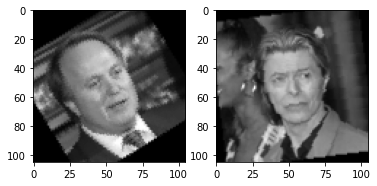

In [25]:
# Testing train Dataset
img1, img2, are_Same = dataset_train[1]

print(are_Same.item())
print(img1.shape,'\n',img2.shape)

# convert to PIL and multiply with std and add mean to un-normalize the images for viewing purposes only
show_img1=transforms.ToPILImage()(img1.mul_(std).add_(mean))
show_img2=transforms.ToPILImage()(img2.mul_(std).add_(mean))

print(show_img1.size,'\n',show_img2.size)

plt.subplot(121)
plt.imshow(show_img1,cmap='gray')

plt.subplot(122)
plt.imshow(show_img2,cmap='gray')

torch.Size([10, 1, 105, 105]) torch.Size([1, 105, 105])


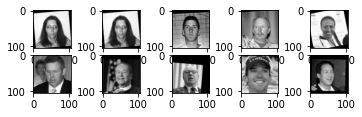

In [26]:
# Testing validation Dataset
imgs=dataset_val[0]

print(imgs.shape, imgs[0,:].shape)

# data_iter=iter(dataloader_val)
# images=data_iter.next()
# print(images.shape) #torch.Size([16, 10, 1, 105, 105])

for i in range(ways):
  img=imgs[i,:]
  plt.subplot(5,5,(i+1))
  plt.imshow(transforms.ToPILImage()(img.mul_(std_val).add_(mean_val)), cmap='gray')

In [27]:
resume_training=False

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)

loss_function=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=3e-4,weight_decay=6e-5)

# lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
# lr_scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, verbose=True)

start_epoch=0
epochs=80

if resume_training:
  checkpoint = torch.load('/content/drive/MyDrive/dataset/ckpts_newest_2/checkp60.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  # loss_function = checkpoint['loss']

In [ ]:
# Train Network

save_ckp_at='/content/drive/MyDrive/DeepFaceLab_2/DeepFaceLab/doc/ckpt_lfw'
t_loss,accuracy=[],[]
val_every=1
save_every=20

for epoch in range(start_epoch, epochs+1):
  t_loss_batch=[]
  
  # ----------------------training---------------------------------------------
  model.train()
  for batch_idx, (img1, img2, isSame) in enumerate(dataloader_train):
    # Get data to cuda if possible
    img1, img2, isSame= img1.to(device),img2.to(device),isSame.to(device)

    # forward
    scores = model(img1, img2)
    loss = loss_function(scores, isSame)
    
    # backward
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    t_loss_batch.append(loss.item())
  
  mean_loss=sum(t_loss_batch)/len(t_loss_batch)
  t_loss.append(mean_loss)
  # ------------------------lr scheduler---------------------------------------------
  
  # for ExponentialLR 
  # lr_scheduler.step()
  
  # forReduceLROnPlateau
  # lr_scheduler.step(mean_loss)
  
  # -----------------------------Validation----------------------------------
  if epoch%val_every==0:
    model.eval()
    with torch.no_grad():
      batch_accuracy=[]
      for batch_idx,images in enumerate(dataloader_val):
        score_l,correct=[],0
        images=images.to(device)
        img1=images[:,0,:]

        for i in range(1,ways):
          score=torch.sigmoid(model(img1,images[:,i,:]))
          score_l.append(score)

        scores=torch.stack(score_l)

        results=torch.argmax(scores,0)

        for i in range(results.shape[0]):
          if results[i,:].item()==0:
            correct+=1

        total=images.shape[0]
        batch_accuracy.append(correct/total)

      # finding the accuracy of that epoch
      accuracy.append(sum(batch_accuracy)/len(batch_accuracy))
    print(f'Epoch No.:{epoch} training loss:{t_loss[-1]}  validation accuracy:{accuracy[-1]*100}%')
  
  if epoch%save_every==0:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': t_loss[-1],
            }, f'{save_ckp_at}/checkp_lfw{epoch}.pt')

In [ ]:
print(f'Mean Loss: {sum(t_loss)/len(t_loss):.3f}')
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()
ax.plot(t_loss,label='Training Loss')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [ ]:
print(f'Mean Accuracy: {sum(accuracy)/len(accuracy)*100:.3f}%')
print(max(accuracy))
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(accuracy,label='Validation accuracy')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')